# [Sec 0] - Data preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
# %% Load data
mnist_cluttered = np.load('./data/mnist_sequence1_sample_5distortions5x5.npz')

In [2]:
X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test = mnist_cluttered['X_test']
y_test = mnist_cluttered['y_test']

In [3]:
def getrotation_img(image,angel):
    image = np.reshape(image, (40, 40))
    rows,cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angel,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

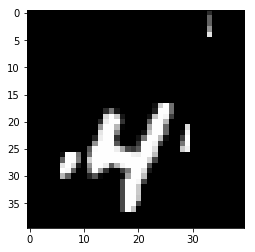

In [8]:
# take a check
dst=getrotation_img(X_train[50, :],0)
plt.imshow(dst, cmap = plt.get_cmap('gray'))

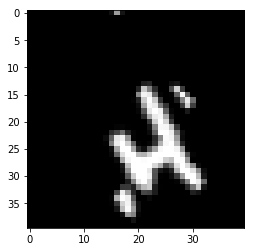

In [9]:
dst=getrotation_img(X_train[50, :],50)
plt.imshow(dst, cmap = plt.get_cmap('gray'))

In [10]:
# make rotated dataset
import random 
def rotation_all(X_train,angle):
    for i in xrange(X_train.shape[0]):
        angle+=random.randint(-20 ,20)
        if i==0:
            X_train_temp=np.reshape(getrotation_img(X_train[i, :],angle), (-1, 1600))
        else:
            temp=np.reshape(getrotation_img(X_train[i, :],angle), (-1, 1600))
            X_train_temp=np.concatenate((X_train_temp, temp), axis=0)
    print "the rotation output : "+str(X_train_temp.shape)
    return X_train_temp


In [11]:
X_train_0=rotation_all(X_train,0)
X_train_0_1=rotation_all(X_train,0)
X_train_45=rotation_all(X_train,45)
X_train_90=rotation_all(X_train,90)
X_train_135=rotation_all(X_train,135)
X_train_180=rotation_all(X_train,180)
X_train_225=rotation_all(X_train,225)
X_train_270=rotation_all(X_train,270)
X_train_315=rotation_all(X_train,315)
X_train=np.concatenate((X_train,X_train_0,X_train_0_1,X_train_45,X_train_90,\
                       X_train_135,X_train_180,X_train_225,\
                       X_train_270,X_train_315),axis=0)

the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)
the rotation output : (10000, 1600)


In [15]:
print X_train.shape

y_train=np.concatenate((y_train,y_train,y_train,y_train,y_train,y_train,\
                        y_train,y_train,y_train,y_train),axis=0)
print y_train.shape

(100000, 1600)
(100000, 1)


In [16]:
# validation set
X_valid_0=rotation_all(X_valid,0)
X_valid_0_1=rotation_all(X_valid,0)
X_valid_45=rotation_all(X_valid,45)
X_valid_90=rotation_all(X_valid,90)
X_valid_135=rotation_all(X_valid,135)
X_valid_180=rotation_all(X_valid,180)
X_valid_225=rotation_all(X_valid,225)
X_valid_270=rotation_all(X_valid,270)
X_valid_315=rotation_all(X_valid,315)
X_valid=np.concatenate((X_valid,X_valid_0,X_valid_0_1,X_valid_45,X_valid_90,\
                       X_valid_135,X_valid_180,X_valid_225,\
                       X_valid_270,X_valid_315),axis=0)
print X_valid.shape
y_valid=np.concatenate((y_valid,y_valid,y_valid,y_valid,y_valid,y_valid,\
                        y_valid,y_valid,y_valid,y_valid),axis=0)
print y_valid.shape

the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
the rotation output : (1000, 1600)
(10000, 1600)
(10000, 1)


In [18]:
np.save("rotated_x_train",X_train)
np.save("rotated_y_train",y_train)
np.save("rotated_x_vali",X_valid)
np.save("rotated_y_vali",y_valid)

# [Sec1]   load data train model

In [1]:
import numpy as np
X_train=np.load("./rotated_x_train.npy")
y_train=np.load("./rotated_y_train.npy").astype(int)
X_valid=np.load("./rotated_x_vali.npy")
y_valid=np.load("./rotated_y_vali.npy").astype(int)

In [2]:
arr = np.arange(X_train.shape[0])
np.random.shuffle(arr)
X_train=X_train[arr]
y_train=y_train[arr]

In [3]:
# Neural Networks
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class LRNet(nn.Module):
    def __init__(self):
        super(LRNet, self).__init__()
        self.fc = nn.Linear(1600, 10)

    def forward(self, x):
        x = self.fc(x)
        return x

net = LRNet()
use_cuda = torch.cuda.is_available()
if use_cuda:
    net.cuda()

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 1e-3, weight_decay=1e-4)

In [13]:
running_loss = 0.0
epoch = 100
batch_size = 200

for epoch_s in range(epoch):
    total = 0
    correct = 0
    for i in range(len(X_train)/batch_size):
        max_idx = min( batch_size*(i+1),len(X_train))
        range_set = range(batch_size*i,max_idx)
        X_tensor = torch.from_numpy(X_train[range_set]) # require shape [N,P]
        y_tensor = torch.from_numpy(y_train[range_set].reshape([-1])) # require shape [C]
        inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        total += y_tensor.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels.data).cpu().sum()
    print ("ecpoch : ", epoch_s,100.*correct/total)
    
    X_tensor = torch.from_numpy(X_valid) 
    y_tensor = torch.from_numpy(y_valid.reshape([-1])) # require shape [C]
    inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    acc_valid=100.*predicted.eq(labels.data).cpu().sum()/len(y_valid)
    print ("====== ecpoch : ", epoch_s , "valid_acc",acc_valid, "==========")


RuntimeError: mismatch between the batch size of input (392) and that of target (200) at /py/conda-bld/pytorch_1493676237139/work/torch/lib/THCUNN/generic/ClassNLLCriterion.cu:39

### CNN

In [4]:
# with only fc  acc ~ 0.29 , Let' build with cnn
import torch.nn.functional as F

class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3,padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(16, 16, 3,padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3,padding=1)
        self.conv4_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_drop(x)
        x = self.pool(F.relu(self.conv4(self.conv3(x))))
        x = self.conv4_drop(x)
        #print x.size()
        x = x.view(-1, 16 * 5 *5)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
net = CNNet()
use_cuda = torch.cuda.is_available()
if use_cuda:
    net.cuda()


In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 1e-3, weight_decay=1e-4)

In [6]:
running_loss = 0.0
epoch = 100
batch_size = 200
def train(epoch_s):
    net.train()
    total = 0
    correct = 0
    for i in range(len(X_train)/batch_size):
        #prepare data
        max_idx = min( batch_size*(i+1),len(X_train))
        range_set = range(batch_size*i,max_idx)
        X_tensor = torch.from_numpy(np.reshape(X_train[range_set], (-1,1,40, 40))) # require shape [N,P]
        y_tensor = torch.from_numpy(y_train[range_set].reshape([-1])) # require shape [C]
        inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
        outputs = net(inputs)
        
        #optimize procedure
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        total += y_tensor.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels.data).cpu().sum()
    print ("ecpoch : ", epoch_s,100.*correct/total)
    
    
def vali(epoch_s):
    net.eval()
    # print validation acc:
    X_tensor = torch.from_numpy(np.reshape(X_valid, (-1,1,40, 40))) 
    y_tensor = torch.from_numpy(y_valid.reshape([-1])) # require shape [C]
    inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    acc_valid=100.*predicted.eq(labels.data).cpu().sum()/len(y_valid)
    print ("====== ecpoch : ", epoch_s , "valid_acc",acc_valid, "==========")

In [7]:
for epoch_s in range(epoch):
    train(epoch_s)
    vali(epoch_s)

('ecpoch : ', 0, 24.41)
('====== ecpoch : ', 0, 'valid_acc', 45.15, '==========')
('ecpoch : ', 1, 42.161)
('====== ecpoch : ', 1, 'valid_acc', 50.78, '==========')
('ecpoch : ', 2, 47.192)
('====== ecpoch : ', 2, 'valid_acc', 57.41, '==========')
('ecpoch : ', 3, 51.539)
('====== ecpoch : ', 3, 'valid_acc', 66.04, '==========')
('ecpoch : ', 4, 56.076)
('====== ecpoch : ', 4, 'valid_acc', 71.84, '==========')
('ecpoch : ', 5, 60.269)
('====== ecpoch : ', 5, 'valid_acc', 75.58, '==========')
('ecpoch : ', 6, 63.043)
('====== ecpoch : ', 6, 'valid_acc', 77.75, '==========')
('ecpoch : ', 7, 65.368)
('====== ecpoch : ', 7, 'valid_acc', 80.14, '==========')
('ecpoch : ', 8, 67.25)
('====== ecpoch : ', 8, 'valid_acc', 81.26, '==========')
('ecpoch : ', 9, 68.611)
('====== ecpoch : ', 9, 'valid_acc', 82.83, '==========')
('ecpoch : ', 10, 69.422)
('====== ecpoch : ', 10, 'valid_acc', 83.52, '==========')
('ecpoch : ', 11, 70.46)
('====== ecpoch : ', 11, 'valid_acc', 84.7, '==========')
('ec

In [23]:
# with naive cnn can easily reach  acc~0.9 
len(X_valid)

10000

# [Sec 2 ] Let begin with STN x FC

In [1]:
import sys
sys.path.append("..") # add the modules.stn path

In [2]:
from __future__ import print_function   
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
import torch.nn.functional as F

from modules.gridgen import CylinderGridGen, AffineGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

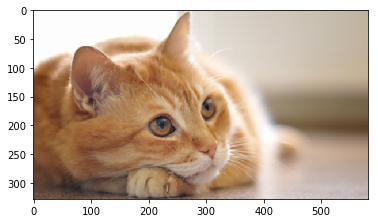

In [3]:
img = Image.open('../cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.imshow(img)

In [4]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages.size()
s = STN()
g = AffineGridGen(200, 200)
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)).cuda(), requires_grad = True)
out = g(input).repeat(20,1,1,1)

input1 = Variable(inputImages.cuda()).repeat(20,1,1,1)
res = s(input1, out)
#print res.size()
#res = res.cpu().data.numpy()

In [5]:
np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)

array([[[ 1. ,  0.5,  0. ],
        [ 0.5,  1. ,  0. ]]], dtype=float32)

In [6]:
res.size()


torch.Size([20, 200, 200, 3])

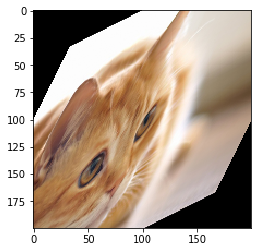

In [7]:
plt.imshow(res.cpu().data.numpy()[1])

In the example  of stn.torch shows that using res to calculate loss , gradient are able to back propagate to parameter of stn (input above)

1. produce the 6 element tensor
2. attach res to loss

In [8]:
import numpy as np
X_train=np.load("./rotated_x_train.npy")
y_train=np.load("./rotated_y_train.npy").astype(int)
X_valid=np.load("./rotated_x_vali.npy")
y_valid=np.load("./rotated_y_vali.npy").astype(int)

In [9]:
arr = np.arange(X_train.shape[0])
np.random.shuffle(arr)
X_train=X_train[arr]
y_train=y_train[arr]

In [23]:
running_loss = 0.0
epoch = 100
batch_size = 200
def train(epoch_s):
    net.train()
    total = 0
    correct = 0
    for i in range(len(X_train)/batch_size):
        #prepare data
        max_idx = min( batch_size*(i+1),len(X_train))
        range_set = range(batch_size*i,max_idx)
        X_tensor = torch.from_numpy(np.reshape(X_train[range_set], (-1,1,40, 40))) # require shape [N,P]
        y_tensor = torch.from_numpy(y_train[range_set].reshape([-1])) # require shape [C]
        inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
        outputs = net(inputs)
        
        #optimize procedure
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        total += y_tensor.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels.data).cpu().sum()
    print ("ecpoch : ", epoch_s,100.*correct/total)
    
    
def vali(epoch_s):
    net.eval()
    # print validation acc:
    X_tensor = torch.from_numpy(np.reshape(X_valid, (-1,1,40, 40))) 
    y_tensor = torch.from_numpy(y_valid.reshape([-1])) # require shape [C]
    inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    acc_valid=100.*predicted.eq(labels.data).cpu().sum()/len(y_valid)
    print ("====== ecpoch : ", epoch_s , "valid_acc",acc_valid, "==========")

In [19]:
class STNNet(nn.Module):
    def __init__(self):
        super(STNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1,stride=2)
        self.conv1_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20*20*32, 256)
        self.stn_fc = nn.Linear(256, 6)
        
        self.s = STN(layout = 'BCHW')
        self.g = AffineGridGen(40, 40)

        # init fix a Identity matrix
        self.stn_fc.bias.data = torch.from_numpy(np.array([1, 0, 0, 0, 1, 0], dtype=np.float32))
        # the classification fc
        self.fc2 = nn.Linear(1600, 10)

    def forward(self, x):
        #============stn==================#
        x1 = F.relu(self.conv1(x))
        #x1 = self.conv1_drop(x1)
        x1 = x1.view(-1,20*20 *32)
        x1 = F.relu(self.fc1(x1))
        theta = self.stn_fc(x1)
        theta = theta.view(-1, 2, 3)
        out = self.g(theta)
        x = x.transpose(1,2).transpose(2,3)
        res = s(x, out)
        
        #===============fc==================#
        res = res.view(-1,40*40)
        result = self.fc2(res) # comment these two line when checking correctness
        #==================================#
        return result

### check if implement is well [this can be skip]

In [29]:
X_tensor = torch.from_numpy(np.reshape(X_train[0:1], (-1,1,40, 40))) # require shape [N,P]
y_tensor = torch.from_numpy(y_train[0].reshape([-1])) # require shape [C]
inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
outputs = net(inputs)
        

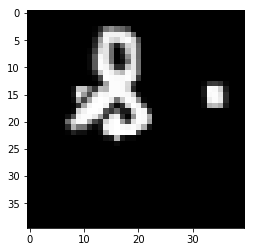

In [40]:
image = np.reshape(X_train[0], (40, 40))
#X_train[0].shape
plt.imshow(image, cmap = plt.get_cmap('gray'))

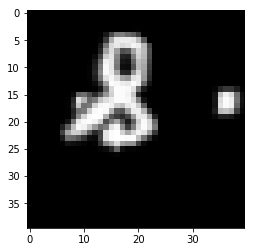

In [45]:
image=outputs.data.cpu().numpy()
image = np.reshape(image, (40, 40))

plt.imshow(image, cmap = plt.get_cmap('gray'))

### let's train it up

In [22]:
import torch.optim as optim

net = STNNet()
use_cuda = torch.cuda.is_available()
if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 1e-3, weight_decay=1e-4)

seems good, let's  build model!!

In [24]:
for epoch_s in range(epoch):
    train(epoch_s)
    if epoch_s%5==0:
        vali(epoch_s)

ecpoch :  0 11.437
====== ecpoch :  0 valid_acc 11.9 ==========
ecpoch :  1 10.83
ecpoch :  2 10.794
ecpoch :  3 30.049
ecpoch :  4 45.643
ecpoch :  5 51.362
====== ecpoch :  5 valid_acc 53.71 ==========
ecpoch :  6 54.772
ecpoch :  7 57.514
ecpoch :  8 59.436
ecpoch :  9 60.42
ecpoch :  10 61.739
====== ecpoch :  10 valid_acc 56.63 ==========
ecpoch :  11 63.142
ecpoch :  12 64.215
ecpoch :  13 64.892
ecpoch :  14 65.886
ecpoch :  15 66.195
====== ecpoch :  15 valid_acc 59.11 ==========
ecpoch :  16 66.776
ecpoch :  17 68.299
ecpoch :  18 69.02
ecpoch :  19 69.126
ecpoch :  20 69.834
====== ecpoch :  20 valid_acc 57.8 ==========
ecpoch :  21 69.941
ecpoch :  22 70.709
ecpoch :  23 71.288
ecpoch :  24 71.398
ecpoch :  25 71.511
====== ecpoch :  25 valid_acc 57.78 ==========
ecpoch :  26 71.865
ecpoch :  27 72.322
ecpoch :  28 73.598
ecpoch :  29 75.106
ecpoch :  30 76.025
====== ecpoch :  30 valid_acc 55.87 ==========
ecpoch :  31 76.681


KeyboardInterrupt: 

stn + fc -> from 30% -> 60%
## Let's build Stn+CNN

In [10]:
class STNCNNet(nn.Module):
    def __init__(self):
        super(STNCNNet, self).__init__()
        self.conv1_loc = nn.Conv2d(1, 32, kernel_size=3,padding=1,stride=2)
        self.fc1_loc = nn.Linear(20*20*32, 256)
        self.stn_fc = nn.Linear(256, 6)
        
        self.s = STN(layout = 'BCHW')
        self.g = AffineGridGen(40, 40)

        # init fix a Identity matrix
        self.stn_fc.bias.data = torch.from_numpy(np.array([1, 0, 0, 0, 1, 0], dtype=np.float32))
        
        # -------- the classification CNN ----------
        self.conv1 = nn.Conv2d(1, 6, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3,padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(16, 16, 3,padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3,padding=1)
        self.conv4_drop = nn.Dropout2d()
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        #============stn==================#
        x1 = F.relu(self.conv1_loc(x))
        x1 = x1.view(-1,20*20 *32)
        #print (x1.size())
        x1 = F.relu(self.fc1_loc(x1))
        theta = self.stn_fc(x1)
        theta = theta.view(-1, 2, 3)
        out = self.g(theta)
        x = x.transpose(1,2).transpose(2,3)
        res = s(x, out)
        
        #===============CNN==================#
        res = res.transpose(1,3).transpose(2,3)
        x = self.pool(F.relu(self.conv1(res)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_drop(x)
        x = self.pool(F.relu(self.conv4(self.conv3(x))))
        x = self.conv4_drop(x)
        #print x.size()
        x = x.view(-1, 16 * 5 *5)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        #==================================#
        return x

In [11]:
import torch.optim as optim

net = STNCNNet()
use_cuda = torch.cuda.is_available()
if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 1e-3, weight_decay=1e-4)

In [12]:
running_loss = 0.0
epoch = 100
batch_size = 100
def train(epoch_s):
    net.train()
    total = 0
    correct = 0
    for i in range(len(X_train)/batch_size):
        #prepare data
        max_idx = min( batch_size*(i+1),len(X_train))
        range_set = range(batch_size*i,max_idx)
        X_tensor = torch.from_numpy(np.reshape(X_train[range_set], (-1,1,40, 40))) # require shape [N,P]
        y_tensor = torch.from_numpy(y_train[range_set].reshape([-1])) # require shape [C]
        inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
        outputs = net(inputs)
        
        #optimize procedure
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        total += y_tensor.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(labels.data).cpu().sum()
    print ("ecpoch : ", epoch_s,100.*correct/total)
    
    
def vali(epoch_s):
    net.eval()
    # print validation acc:
    X_tensor = torch.from_numpy(np.reshape(X_valid, (-1,1,40, 40))) 
    y_tensor = torch.from_numpy(y_valid.reshape([-1])) # require shape [C]
    inputs, labels = Variable(X_tensor.cuda()), Variable(y_tensor.cuda())
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    acc_valid=100.*predicted.eq(labels.data).cpu().sum()/len(y_valid)
    print ("====== ecpoch : ", epoch_s , "valid_acc",acc_valid, "==========")

seems good, let's  build model!!

In [ ]:
for epoch_s in range(epoch):
    train(epoch_s)
    if epoch_s%5==0:
        vali(epoch_s)

ecpoch :  0 89.481
====== ecpoch :  0 valid_acc 91.64 ==========
ecpoch :  1 89.614
ecpoch :  2 89.653
ecpoch :  3 89.911
ecpoch :  4 89.624
ecpoch :  5 89.817
====== ecpoch :  5 valid_acc 91.07 ==========
ecpoch :  6 89.708
ecpoch :  7 89.838
ecpoch :  8 89.854
ecpoch :  9 90.023
ecpoch :  10 90.014
====== ecpoch :  10 valid_acc 92.05 ==========
ecpoch :  11 90.043
ecpoch :  12 90.211
ecpoch :  13 89.942
ecpoch :  14 90.214


In [15]:
# reach ~ 0.92 acc

====== ecpoch :  99 valid_acc 92.23 ==========
